In [1]:
from QwenMCQA import *

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [2]:
import random

def generate_labels(n, enumerative = True, enforced_style = None):
	if enumerative or enforced_style is not None:
		element_styles = ['upper', 'lower', 'digit']
		element_probs  = [0.8, 0.1, 0.1]
        #element_probs  = [1, 0, 0]
		patterns       = ['_.', '_)', '(_)', '_ -']
		pattern_probs  = [0.7, 0.15, 0.1, 0.05]
        #pattern_probs  = [1, 0, 0, 0]

		if enforced_style is None:
			style_elem = random.choices(element_styles, weights=element_probs, k=1)[0]
			style_pat  = random.choices(patterns,      weights=pattern_probs,  k=1)[0]
		else:
			style_elem, style_pat = enforced_style

		funcs = {
			'upper': lambda i: chr(65 + i % 26),
			'lower': lambda i: chr(97 + i % 26),
			'digit': lambda i: str(i + 1)
		}

		labels = [style_pat.replace('_', funcs[style_elem](i)) for i in range(n)]
		naked_labels = [funcs[style_elem](i) for i in range(n)]
		return labels, naked_labels
	else:
		patterns = ['', '-', '*']
		pattern_probs = [0.7, 0.2, 0.1]

		style_pat = random.choices(patterns, weights=pattern_probs, k=1)[0]

		return [style_pat for _ in range(n)]

import random
import numpy as np

def prompt_creator(example, cot_prob = 0.5, random_seed=None):
	if random_seed is not None:
		random.seed(random_seed)

	#You are a precise STEM multiple-choice question solver. 0.5

	subjects = {'aqua_rat' : 'math',
				'medmcqa' : 'medicine',
				'mmlu_aux' : 'STEM',
				'openbookqa' : 'STEM',
				'sciq' : 'STEM'}
	
	enforced_styles = {'aqua_rat' : ('upper', '_.'),
						'medmcqa' : ('lower', '_.'),
						'mmlu_aux' : None,
						'openbookqa' : ('upper', '_.'),
						'sciq' : ('upper', '_.')}
	
	topic = f"knowledge and skills in advanced master-level {subjects[example['dataset']]} courses"
	setup = random.choices([f'The following are multiple choice questions (with answers) about {topic}.\n',
							f'The following are multiple choice questions (with answers).\n',
							f'Answer the following multiple choice question.\n'],
							weights=[0.8, 0.1, 0.1],
                            #weights=[1, 0, 0], 
							k=1)[0]

	cot = ''
	doing_cot = random.random() < cot_prob
	enforced_style = None
	if example['rationale'] != "" and doing_cot:
		cot = random.choices([f'Think step by step (before answering).\n<think>\n{example["rationale"]}\n</think>',
						f'Solve step-by-step.\n<think>\n{example["rationale"]}\n</think>',
						f'Reason step by step.\n<think>\n{example["rationale"]}\n</think>'],
						weights=[0.8, 0.1, 0.1],
						k=1)[0]
		enforced_style = enforced_styles[example['dataset']]

	golden_idx = example["label_idx"]
	n_words_avg = np.mean([len(option.split()) for option in example["options"]])
    full_option_prob = 0.15
    #full_option_prob = 0
	full_option = random.random() < full_option_prob if n_words_avg <= 4 else 0
	if not full_option or doing_cot:
		labels, naked_labels = generate_labels(5, enforced_style=enforced_style)
		golden_answer = naked_labels[golden_idx]
	else:
		labels = generate_labels(5, enumerative=False)
		golden_answer = example["options"][golden_idx]

	options = [f"{label} {option}".strip() for label, option in zip(labels, example["options"])]

	lines = [setup, example["question"]] + options + [cot, 'Answer:']

	return '\n'.join(lines), golden_answer

def preprocess(example,
               tokenizer,
               max_length,
               tokenized_marker,
               cot_prob):

    def find_last_subseq(seq, pat):
        for i in range(len(seq) - len(pat), -1, -1):
            if seq[i : i+len(pat)] == pat:
                return i + len(pat) - 1
        raise ValueError("Could not find marker")

    prompt, golden_answer = prompt_creator(example, cot_prob)

    choice_ids = tokenizer.encode(f" {golden_answer}", add_special_tokens=False)
    n_answer = len(choice_ids)

    tok = tokenizer(
        prompt,
        max_length=max_length - n_answer,
        truncation=True,
        padding=False,
    )

    pad_len = max_length - len(tok["input_ids"])
    tok["input_ids"]      += [tokenizer.pad_token_id] * pad_len
    tok["attention_mask"] += [0] * pad_len

    labels = [-100] * max_length
    ans_pos = find_last_subseq(tok["input_ids"], tokenized_marker)
    if ans_pos + 1 + n_answer > max_length:
        raise ValueError("Not enough room for answer tokens")
    for i, tid in enumerate(choice_ids):
        labels[ans_pos + 1 + i] = tid

    return {
        "input_ids":      tok["input_ids"],
        "attention_mask": tok["attention_mask"],
        "labels":         labels,
    }

In [3]:
from functools import partial
p = 0

preprocess_cot_prob_p = partial(preprocess, cot_prob=p)

qwenMCQA = QwenMCQA(
            preprocess_cot_prob_p,
            my_model_name = 'cot00_e2',
            num_epochs = 2,
            batch_size = 128,
            gradient_accumulation_steps = 2,
            #save_steps = 16,
            #logging_steps = 2,
            #data_subset = 50
            )

README.md:   0%|          | 0.00/5.81k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/200000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/519 [00:00<?, ? examples/s]

==((====))==  Unsloth 2025.5.7: Fast Qwen3 patching. Transformers: 4.51.3.
   \\   /|    NVIDIA A100-SXM4-40GB MIG 3g.20gb. Num GPUs = 1. Max memory: 19.625 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 8.0. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


/home/my_venvs/mnlp_m2c/lib/python3.12/site-packages/awq/__init__.py:21: DeprecationWarning: 
I have left this message as the final dev message to help you transition.

Important Notice:
- AutoAWQ is officially deprecated and will no longer be maintained.
- The last tested configuration used Torch 2.6.0 and Transformers 4.51.3.
- If future versions of Transformers break AutoAWQ compatibility, please report the issue to the Transformers project.

Alternative:
- AutoAWQ has been adopted by the vLLM Project: https://github.com/vllm-project/llm-compressor

For further inquiries, feel free to reach out:
- X: https://x.com/casper_hansen_
- LinkedIn: https://www.linkedin.com/in/casper-hansen-804005170/

  warnings.warn(_FINAL_DEV_MESSAGE, category=DeprecationWarning, stacklevel=1)


Unsloth: Making `model.base_model.model.model` require gradients


/home/my_venvs/mnlp_m2c/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/200000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

/home/my_venvs/mnlp_m2c/lib/python3.12/site-packages/google/protobuf/internal/well_known_types.py:91: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  _EPOCH_DATETIME_NAIVE = datetime.datetime.utcfromtimestamp(0)


Starting training with LoRA adapters...
🔄  No checkpoint found, starting from scratch …


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 200,000 | Num Epochs = 2 | Total steps = 1,562
O^O/ \_/ \    Batch size per device = 128 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (128 x 2 x 1) = 256
 "-____-"     Trainable parameters = 66,060,288/6,000,000,000 (1.10% trained)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
10,4.226300
20,3.627600
30,3.245400
40,2.379600
50,1.886300
60,1.600600
70,1.510600
80,1.400300
90,1.439200
100,1.382400


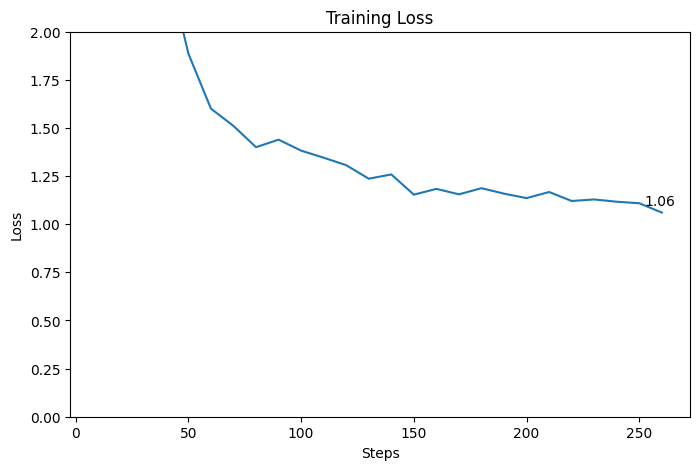

In [ ]:
qwenMCQA.train()
qwenMCQA.merge()